In [1]:
%load_ext autoreload

%autoreload 2
import sys
import numpy as np
import matplotlib.pyplot as plt
import see_fits
import scipy
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
from scipy.ndimage import gaussian_filter
sys.path.append('../modules')
import covariance as covar
import utils
import abundance as cl_count
import forecast
import pyccl as ccl
import edit
import h5py
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

In [2]:
a=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Covariance_cluster_abudance_{4}x{4}.pickle')

In [3]:
def cov_freq(nz, nm):
    cov_gauss=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Covariance_cluster_abudance_{nz}x{nm}.pickle')
    Abundance=edit.load_pickle(f'/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Abundance_{nz}x{nm}.pickle')
    cov_poiss=np.diag(Abundance.flatten())
    SigmaPGP = np.linalg.inv(cov_poiss) @ (cov_gauss @ np.linalg.inv(cov_poiss))
    
    f=forecast.Forecast()
    z_grid = np.linspace(0.18, 1.3, 1500)
    logm_grid = np.linspace(14.1,15.8, 1500)
    z_corner = np.linspace(0.2, 1.2, nz + 1)
    logm_corner = np.linspace(14.2, 15.6, nm + 1)
    Z_bin = binning(z_corner)
    logMass_bin = binning(logm_corner)
    clc = cl_count.ClusterAbundance()
    clc.sky_area = (0.25)*4*np.pi
    clc.f_sky = clc.sky_area/(4*np.pi)
    clc.z_grid=z_grid
    clc.logm_grid=logm_grid
    def model(theta):
        "predictiing cluster count"
        Om_v, s8_v = theta
        #re-compute ccl cosmology
        cosmo_new = ccl.Cosmology(Omega_c = Om_v - 0.048254, Omega_b = 0.048254, 
                                  h = 0.6777, sigma8 = s8_v, n_s=0.96)
        massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
        hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo_new, mass_def=massdef)
        clc.set_cosmology(cosmo = cosmo_new, hmd = hmd, massdef = massdef)
        #re-compute integrand
        clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
        return clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, 
                                        method = 'simps')
    def model_flat(theta):
        return model(theta).flatten()
    
    d_Abundance=forecast.first_derivative(True_value, model, (nz,nm), delta = 1e-5)
    return forecast.cov_Frequentist(forecastF[f'{nz}zx{nm}m']['Poissonian'], d_Abundance, SigmaPGP)

In [4]:
binnings=['4zx4m','20zx30m','100zx100m']

In [5]:
covFreq={b:None for b in binnings}

In [6]:
forecastF=edit.load_pickle('/pbs/throng/lsst/users/cpayerne/ClusterLikelihoods_data/Covariances/Fisher_covariance.pickle')

In [7]:
covFreq[binnings[0]] = cov_freq(4,4)

In [8]:
covFreq

{'4zx4m': array([[ 6.51231579e-06, -3.28089837e-06],
        [-3.28089837e-06,  2.04489398e-06]]),
 '20zx30m': None,
 '100zx100m': None}

In [9]:
covFreq[binnings[1]] = cov_freq(20,30)

In [10]:
covFreq[binnings[2]] = cov_freq(100,100)

In [11]:
likelihood=['Poissonian','Gaussian', 'MPG']
cosmology = {binnings[i]:{likelihood_:None for likelihood_ in likelihood} for i in range(len(binnings))}
for b in binnings:
    #try:
    cosmology[b]['Poissonian']=see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion/P*')
    cosmology[b]['Gaussian']  =see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion/Gaussian*')
    cosmology[b]['MPG']       =see_fits.mean_var_covar('/sps/lsst/users/cpayerne/1000xsimulations/analysis/'+b+'/mean_dispersion/MPG*')
    #except: 
    #    continue

In [12]:
len(cosmology['100zx100m']['MPG'] )

999

1000
999
1000
1000
1000
840
999
955
999
-0.20000000000000004


/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Saw kw

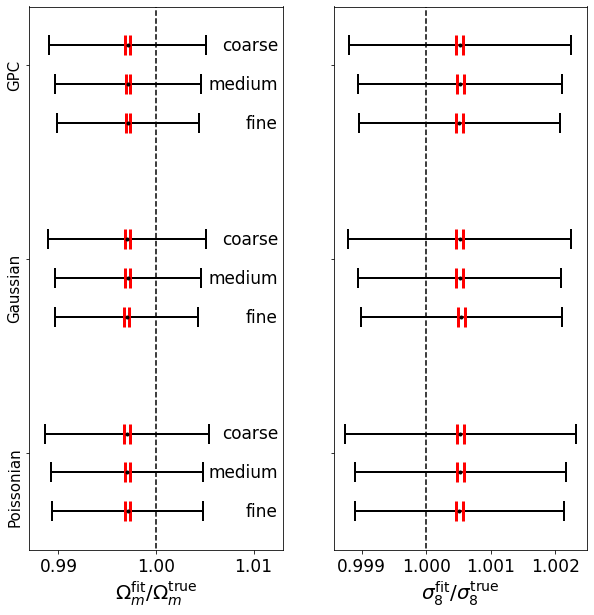

In [13]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
#colors=['k', 'k', 'k']
likelihood = ['Poissonian', 'Gaussian', 'MPG']
title = ['Poissonian', 'Gaussian', 'GPC']
fig, ax = plt.subplots(1,2,figsize=(10, 10), sharey=True)
plt.rcParams['axes.linewidth']= 1.5
x1=[]
bname = ['coarse', 'medium', 'fine']
for i, l in enumerate(likelihood):
    w = [i - .2*k for k, b in enumerate(binnings)]
    x1.append(np.mean(w))
    for j, b in enumerate(binnings):
        Om=cosmology[b][l]['Om']
        errOm = np.std(Om)
        
        meanOm = np.mean(Om)
        print(len(Om))
        #ax[0].scatter(meanOm/(Omega_c_true + Omega_b_true), w[j], s=10, facecolors='w',edgecolor=colors[j],linewidth=2, zorder=1000)
        ax[0].errorbar(meanOm/(Omega_c_true + Omega_b_true), w[j], c='k',yerr=None, xerr=errOm/(Omega_c_true + Omega_b_true), 
                       capsize=10, markersize=3, marker='o', color='k', capthick=2, elinewidth=2, fmt='.')

        ax[0].errorbar(meanOm/(Omega_c_true + Omega_b_true), w[j], c='k',yerr=None, xerr=(errOm/(Omega_c_true + Omega_b_true))/np.sqrt(len(Om)), 
                       capsize=10, markersize=0, marker='o', color='r'
                       , capthick=3, elinewidth=0)

        s8=cosmology[b][l]['s8']
        errs8 = np.std(s8)
   
        means8 = np.mean(s8)
        #ax[1].scatter(means8/(sigma8_true), w[j], s=100, facecolors='w',edgecolor=colors[j],linewidth=2, zorder=1000)
        ax[1].errorbar(means8/(sigma8_true), w[j], c='k',yerr=None, xerr=errs8/(sigma8_true), 
                       capsize=10, markersize=3, marker='o', color='k', capthick=2, elinewidth=2)
        ax[1].errorbar(means8/(sigma8_true), w[j], c='k',yerr=None, xerr=(errs8/(sigma8_true))/np.sqrt(len(Om)), 
                       capsize=10, markersize=0, marker='o', color='r', capthick=3, elinewidth=0)
        ax[0].text(1 + .0125, w[j] + .0, bname[j], horizontalalignment='right', verticalalignment='center',fontsize = 17)
print(np.min(x1))
squad = title
ax[0].set_xlabel(r'$\Omega_m^{\rm fit}/\Omega_m^{\rm true}$', fontsize = 20)
ax[1].set_xlabel(r'$\sigma_8^{\rm fit}/\sigma_8^{\rm true}$', fontsize = 20)
epsi1=.013
epsi2=0.004
ax[0].set_xlim(1-epsi1, 1+epsi1)
#ax[1].set_xlim(1-epsi2, 1+epsi2)
for i in range(2):
    ax[i].vlines(1, -1, 3, linestyle='--')
    ax[i].set_ylim(np.min(x1)-.4, np.max(x1)+.4)
    ax[i].set_yticks(np.array(x1)+.1)
    ax[i].tick_params(axis='both', which = 'major', labelsize= 17)
    ax[i].set_yticklabels(squad, fontsize=15, rotation=90)
#plt.xticklabels(squad, fontsize=15, rotation=30)
plt.savefig('distribution_of_means_2.pdf', bbox_inches='tight', dpi=300)

In [14]:
(Omega_c_true + Omega_b_true)

0.30711

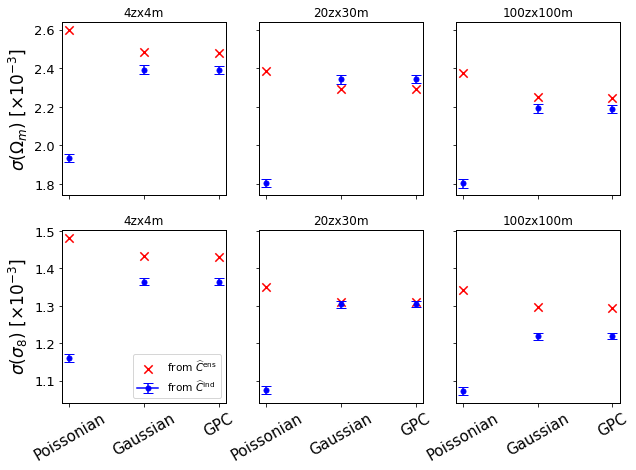

In [23]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
colors=['k', 'k', 'k']
likelihood = ['Poissonian', 'Gaussian', 'MPG']
title = ['Poissonian', 'Gaussian', 'GPC']
fig, ax=plt.subplots(2,3,figsize=(10,7), sharey='row', sharex=True)
plt.rcParams['axes.linewidth']= 1
err=1e3
for i, b in enumerate(binnings):
    for j,l in enumerate(likelihood):
        Om=cosmology[b][l]['Om']
        Omstd=cosmology[b][l]['Om_std']
        s8=cosmology[b][l]['s8']
        s8std=cosmology[b][l]['s8_std']
        ax[0,i].errorbar(j, err*np.mean(Omstd), yerr=err*np.std(Omstd), marker='o', c='b', markersize=5, capsize=5)
        ax[1,i].errorbar(j, err*np.mean(s8std), yerr=err*np.std(s8std), marker='o', c='b', markersize=5, capsize=5)
        ax[0,i].scatter(j,err*np.std(Om), marker='x', c='r', s=70)
        ax[1,i].scatter(j,err*np.std(s8), marker='x', c='r', s=70)
        try:
            cov_Fisher=forecastF[b][l]
            #ax[0,i].scatter(j,err*cov_Fisher[0,0]**.5, marker='o', s=100, facecolors='none',edgecolor='k',linewidth=2, zorder=0)
            #ax[1,i].scatter(j,err*cov_Fisher[1,1]**.5, marker='o', s=100, facecolors='none',edgecolor='k',linewidth=2, zorder=0)
        except: a=1
        if l=='Poissonian':
            a=1
            #ax[0,i].scatter(j,err*covFreq[b][0,0]**.5, marker='s', s=100,facecolors='none',edgecolor='k',linewidth=2, zorder=0)
            #ax[1,i].scatter(j,err*covFreq[b][1,1]**.5, marker='s', s=100,facecolors='none',edgecolor='k',linewidth=2, zorder=0)

    x1 = [0,1,2]
    squad = likelihood
ax[1,0].errorbar([],[], yerr=[], marker='o', c='b', markersize=5, capsize=5, label=r'from $\widehat{C}^{\rm ind}$')
#ax[1,0].scatter([],[], marker='o',s=100, facecolors='none',edgecolor='k',linewidth=2, label='Fisher forecast')
#ax[1,0].scatter([],[], marker='s',s=100, facecolors='none',edgecolor='k',linewidth=2, label='Ensemble forecast')
ax[1,0].scatter([], [], marker='x', c='r', s=70, label=r'from $\widehat{C}^{\rm ens}$')
ax[1,0].legend(frameon=True,fontsize=10.5, loc='lower right')
for i in range(2):
    for j in range(3):
        ax[i,j].set_title(binnings[j])
        ax[i,j].set_xticks(x1)
        ax[i,j].tick_params(axis='both', which = 'major', labelsize= 13)
        ax[i,j].set_xticklabels(title, fontsize=15, rotation=30)
ax[0,0].set_ylabel(r'$\sigma(\Omega_m)\ [\times 10^{-3}]$', fontsize = 17)
ax[1,0].set_ylabel(r'$\sigma(\sigma_8)\ [\times 10^{-3}]$', fontsize = 17)
#fig.delaxes(ax[0,0])
#fig.delaxes(ax[0,1])
#fig.delaxes(ax[0,2])
#fig.delaxes(ax[1,1])
#fig.delaxes(ax[1,2])
plt.savefig('full_std_2.pdf', bbox_inches='tight', dpi=300)

1
1
1
1
1
1


Text(0, 0.5, '$\\rho$')

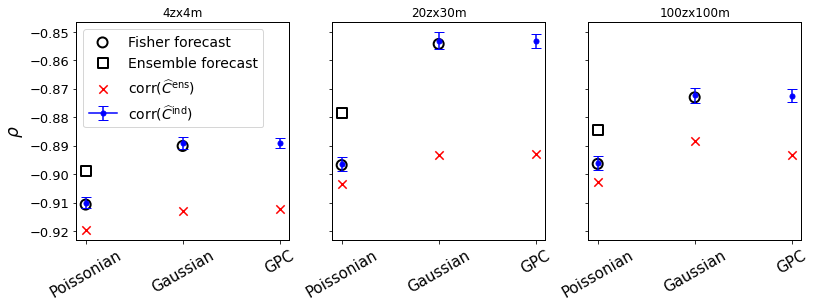

In [16]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
colors=['k', 'k', 'k']
likelihood = ['Poissonian', 'Gaussian', 'MPG']
title = ['Poissonian', 'Gaussian', 'GPC']
fig, ax=plt.subplots(1,3,figsize=(13,4), sharey='row', sharex=True)
plt.rcParams['axes.linewidth']= 1
err=1e3
for i, b in enumerate(binnings):
    for j,l in enumerate(likelihood):
        Om=cosmology[b][l]['Om']
        Omstd=cosmology[b][l]['Om_std']
        s8=cosmology[b][l]['s8']
        s8std=cosmology[b][l]['s8_std']
        cov = np.cov(Om, s8)
        ax[i].scatter(j, cov[0,1]/np.sqrt(cov[1,1]*cov[0,0]), marker='x', c='r', s=70)
        corr_individual = [cosmology[b][l]['cov'][i][0,1]/np.sqrt(cosmology[b][l]['cov'][i][0,0]*cosmology[b][l]['cov'][i][1,1]) for i in range(len(cosmology[b][l]))]
        ax[i].errorbar(j, np.mean(corr_individual), yerr=np.std(corr_individual), marker='o', c='b', markersize=5, capsize=5)
       
        #try:
        if l!='MPG':
            print(1)
            cov_Fisher=forecastF[b][l]
            corr = cov_Fisher[0,1]/np.sqrt(cov_Fisher[0,0]*cov_Fisher[1,1])
            ax[i].scatter(j, corr, marker='o', s=100, facecolors='none',edgecolor='k',linewidth=2, zorder=0)
        if l=='Poissonian':
            c = covFreq[b]
            corr_freq = c[0,1]/np.sqrt(c[0,0]*c[1,1])
            ax[i].scatter(j,corr_freq, marker='s', s=100,facecolors='none',edgecolor='k',linewidth=2, zorder=0)
            
       # if l=='Poissonian':
       #     ax[0,i].scatter(j,err*covFreq[b][0,0]**.5, marker='s', s=100,facecolors='none',edgecolor='k',linewidth=2, zorder=0)
       #     ax[1,i].scatter(j,err*covFreq[b][1,1]**.5, marker='s', s=100,facecolors='none',edgecolor='k',linewidth=2, zorder=0)

   # x1 = [0,1,2]
   # squad = likelihood
ax[0].errorbar([],[], yerr=[], marker='o', c='b', markersize=5, capsize=5, label=r'corr($\widehat{C}^{\rm ind}$)')
ax[0].scatter([],[], marker='o',s=100, facecolors='none',edgecolor='k',linewidth=2, label='Fisher forecast')
ax[0].scatter([],[], marker='s',s=100, facecolors='none',edgecolor='k',linewidth=2, label='Ensemble forecast')
ax[0].scatter([], [], marker='x', c='r', s=70, label=r'corr($\widehat{C}^{\rm ens}$)')
ax[0].legend(frameon=True,fontsize=14, loc='upper left')

for j in range(3):
    ax[j].set_title(binnings[j])
    ax[j].set_xticks(x1)
    ax[j].tick_params(axis='both', which = 'major', labelsize= 13)
    ax[j].set_xticklabels(title, fontsize=15, rotation=30)
ax[0].set_ylabel(r'$\rho$', fontsize = 17)
#ax[1,0].set_ylabel(r'$\sigma(\sigma_8)\ [\times 10^{-3}]$', fontsize = 17)
#plt.savefig('full_rho.pdf', bbox_inches='tight', dpi=300)

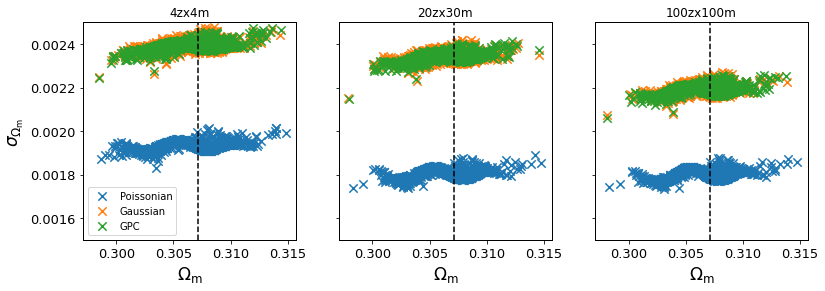

In [56]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c',]
colors=['k', 'k', 'k']
likelihood = ['Poissonian', 'Gaussian', 'MPG']
title = ['Poissonian', 'Gaussian', 'GPC']
fig, ax=plt.subplots(1,3,figsize=(13,4), sharey='row', sharex=True)
plt.rcParams['axes.linewidth']= 1
err=1e3
for i, b in enumerate(binnings):
    for j,l in enumerate(likelihood):
        Om=cosmology[b][l]['Om']
        Omstd=cosmology[b][l]['Om_std']
        s8=cosmology[b][l]['s8']
        s8std=cosmology[b][l]['s8_std']
        ax[i].scatter(Om, Omstd, marker='x', s=70, label = title[j])
        ax[i].set_title(b)

for j in range(3):
    ax[j].set_ylim(0.0015, 0.0025)
    ax[j].vlines(Omegam_true, 0, 1, ls = '--')
    ax[j].tick_params(axis='both', which = 'major', labelsize= 13)
    ax[j].set_xlabel(r'$\Omega_{\rm m}$', fontsize = 17)
ax[0].set_ylabel(r'$\sigma_{\Omega_{\rm m}}$', fontsize = 17)
ax[0].legend()
#ax[1,0].set_ylabel(r'$\sigma(\sigma_8)\ [\times 10^{-3}]$', fontsize = 17)
plt.savefig('sigmaOm_vs_Om.pdf', bbox_inches='tight', dpi=300)